In [1]:
!pip3 install torch_sparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


import math
import time

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 7
#set the random seeds 
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

epochs = 200
lr = 0.01
weight_decay = 5e-4
hidden_units = 16
dropout = 0.5

# Dataset Preprocessing


In [4]:
import zipfile
         
zip = zipfile.ZipFile('/content/data (mod).zip')
zip.extractall('/content')

zip.close()

In [5]:
#per season adjaceny matrix, features of every node


def load_data(season_no):

  #read the edge and node files
  dir = "./data/"
  edge_file = dir + "got-s" + str(season_no) + "-edges.csv"
  node_file = dir + "got-s" + str(season_no) + "-m-nodes.csv"

  edges = pd.read_csv(edge_file)
  nodes = pd.read_csv(node_file)
  
  
  #only get those edges where the nodes are present
  node_ids = nodes['CHARACTERS ID']
#   print(node_ids.head())
  node_ids_reverse = node_ids.to_dict()
  node_ids = {v: k for k, v in node_ids_reverse.items()}
#   print(len(node_ids))
  
  #remove unnecessary columns
  features = nodes.drop(['CHARACTERS ID'], axis=1)
  features = (features-features.mean())/features.std()
  features = torch.from_numpy(features.to_numpy().astype(np.float32))
  edges = edges.drop(['Season'], axis=1)
  
  # initializing graph
  gr = nx.Graph()
  gr.add_nodes_from([i for i in range(len(node_ids))])

  #Adjacency matrix
  adj = np.zeros( (len(node_ids),len(node_ids)) )

  for i in range(len(edges)):
    if edges.iloc[i]['Source'] in node_ids and edges.iloc[i]['Target'] in node_ids:
      src_index = node_ids[edges.iloc[i]['Source']]
      dst_index = node_ids[edges.iloc[i]['Target']]
      gr.add_edge(src_index, dst_index, weight=edges.iloc[i]['Weight'])
      adj[src_index][dst_index] = edges.iloc[i]['Weight']
      adj[dst_index][src_index] = edges.iloc[i]['Weight']

  adj = torch.from_numpy(adj.astype(np.float32))

  return features, adj, gr, node_ids

  #return torch.from_numpy(features.to_numpy()), torch.from_numpy(adj), gr, node_ids
  #return nodes, edges



features, adj, graph, node_ids = load_data(1)

In [11]:
def get_ranking(G, bound):
    dc = dict(G.degree())
    wdc = dict(G.degree(weight='weight'))
    ec = nx.eigenvector_centrality(G, weight='weigth')
    pg = nx.pagerank(G, weight='weigth')
    bc = nx.betweenness_centrality(G, weight='weigth')
    for n in G.nodes():
        ec[n] = round(ec[n], 3)
        pg[n] = round(pg[n], 3)
        bc[n] = round(bc[n], 3)

    dict_list = [dc, wdc, ec, pg, bc]
    # ranking_list = []
    ranking = {}
    for d in dict_list:
        sorted_dict = sorted(d.items(), key = lambda item: item[1], reverse = True)
        sorted_array = np.array(sorted_dict)
        # ranking_list += [sorted_array]
        
        ten_nodes = sorted_array[0:bound][:, 0]
        for n in ten_nodes:
            if n not in ranking:
                ranking[int(n)] = 1
            else:
                ranking[int(n)] = ranking[int(n)] + 1

    return ranking, dict_list

ranking, dict_list = get_ranking(graph, 10)
ranking

{22: 5,
 27: 5,
 4: 5,
 36: 5,
 5: 5,
 26: 5,
 15: 5,
 0: 4,
 13: 4,
 16: 2,
 6: 1,
 30: 1,
 38: 2,
 37: 1}

In [12]:
degree = []
weighted_degree = []
eigenvector = []
pagerank = []
betweenness = []

ranked_nodes = [22, 27, 4, 36, 5, 26, 15]  # season 1
for n in ranked_nodes:
    degree += [dict_list[0][n]]
    weighted_degree += [dict_list[1][n]]
    eigenvector += [dict_list[2][n]]
    pagerank += [dict_list[3][n]]
    betweenness += [dict_list[4][n]]

node_ids_reverse = {v: k for k, v in node_ids.items()}
ranked_nodes_name = [node_ids_reverse[n] for n in ranked_nodes]

ranking_dict = {'Node': ranked_nodes_name,
                'Degree': degree,
                'Weighted Degree': weighted_degree,
                'Eigenvector': eigenvector,
                'Pagerank': pagerank,
                'Betweenness': betweenness}

df_ranking = pd.DataFrame(ranking_dict)
df_ranking

,Node,Degree,Weighted Degree,Eigenvector,Pagerank,Betweenness
0,NED,19,820,0.307,0.066,0.043
1,ROBERT,19,427,0.297,0.068,0.066
2,CATELYN,16,371,0.286,0.055,0.019
3,TYRION,16,460,0.274,0.056,0.031
4,CERSEI,15,386,0.279,0.051,0.007
5,ROBB,15,321,0.281,0.051,0.008
6,JOFFREY,14,274,0.259,0.049,0.013


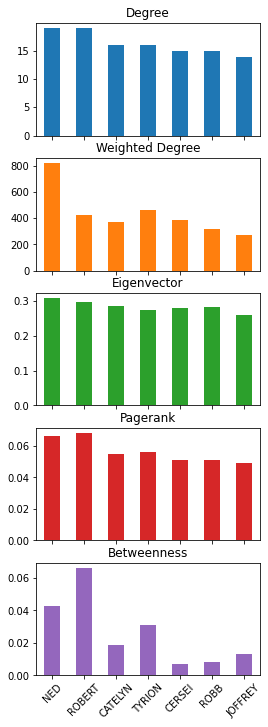

In [13]:
plot = df_ranking.plot(kind='bar', figsize=(4,12),fontsize=10, subplots=True, legend=None)
for p in plot:
    # p.set_xticks(df_ranking.index)
    p.set_xticklabels(df_ranking['Node'], rotation=45)
plt.show()

# Per Season Graph

# Generative Model

In [14]:
class GraphConvolution(Module):
  def __init__(self, in_features, out_features, bias=True):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
        self.bias = Parameter(torch.FloatTensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()
 
  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.mm(adj, support)
    if self.bias is not None:
        return output + self.bias
    else:
        return output

  def __repr__(self):
    return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

In [15]:
class Encoder(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout):
    super(Encoder, self).__init__()

    self.conv = GraphConvolution(nfeat, nhid)
    self.mu = GraphConvolution(nhid, nclass)   # 둘이 같은 거 아닌가
    self.sig = GraphConvolution(nhid, nclass)  # 

    
    self.dropout = dropout
    self.embeddings = []

  def forward(self, x, adj, save_embeddings = False):
    x = F.relu(self.conv(x, adj))
    mu = self.mu(x, adj)
    logvar = self.sig(x, adj)
    return mu, logvar
    

In [ ]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    self.decoder = InnerProductDecoder()
    


  def forward_all(self, x, sigmoid = 'True'):
    #first find whether there is edge or not => THis would be the reconstruction loss
    #then find the weights
    y = self.decoder.forward_all(x, sigmoid = sigmoid)
    return y

  def forward(self, x, edge_index , sigmoid = 'True'):
    y = self.decoder(x, edge_index, sigmoid = sigmoid)
    return y





In [ ]:
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops

class DeepVGAE(VGAE):
  def __init__(self):
    super(DeepVGAE, self).__init__(encoder=Encoder(10, 20, 1, dropout), decoder= Decoder(42,1))


  def forward(self, x, adj):
    z = self.encode(x, adj)
    adj_pred = self.decoder.forward_all(z)
    return adj_pred

  def loss(self, x, adj, pos_edge_index, all_edge_index):
    z = self.encode(x, adj)

    kl_loss = 1 / x.size(0) * self.kl_loss()

    return self.recon_loss(z, pos_edge_index) + kl_loss



In [ ]:
enc = Encoder(10, 20, 1, dropout)

In [ ]:
model = DeepVGAE()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
out = model(features, adj)


In [ ]:
l = model.loss(features, adj, pyg_graph.edge_index, pyg_graph.edge_index)
print(l)
l.backward()

In [ ]:
optimizer.step()

NameError: ignored

In [ ]:
from torch_geometric.utils.convert import from_networkx
pyg_graph = from_networkx(graph)